In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from sklearn.model_selection import train_test_split
import sys
sys.path.append("../")

from cfmining.algorithms import MAPOFCEM
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import GeneralClassifier_Shap
from cfmining.action_set import ActionSet
from cfmining.utils import get_data_model

import dice_ml


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
X_train, Y_train, model, outlier_detection, individuals = get_data_model("german")

In [4]:
action_set = ActionSet(X = X_train)
not_mutable_features = ['Age', 'OwnsHouse', 'isMale', 'JobClassIsSkilled', 'Single', 'ForeignWorker', 'RentsHouse']
mutable_features = [feat for feat in X_train.columns if feat not in not_mutable_features]
continuous_features = ['Age', 'LoanDuration', 'LoanAmount', 'LoanRateAsPercentOfIncome','YearsAtCurrentHome']
for feat in action_set:
    if feat.name in not_mutable_features:
        feat.mutable = False
    if not feat.name in not_mutable_features:
        feat.mutable = True

    feat.step_direction = 0
    feat.update_grid()
percCalc = PercentileCalculator(action_set = action_set)

In [54]:
def summarize_results(results):
    results["individual"] = results["individual"].apply(literal_eval)
    results["solutions"] = results["solutions"].apply(literal_eval)
    results["outlier"] = results["outlier"].apply(lambda x : literal_eval(x)[0])
    costs = []
    for i in range(len(results)):
        criteria = PercentileCriterion(individuals.iloc[i].values, percCalc)
        solutions = results["solutions"].iloc[i]
        costs_ = [criteria.f(s) for s in solutions][0]
        costs.append(costs_)
    results["costs"] = costs

    print(f"Time: {results['time'].mean():.3f} +- {results['time'].std():.3f}")
    print(f"Costs: {results['costs'].mean():.3f} +- {results['costs'].std():.3f}")
    print(f"Outliers: {results['outlier'].mean():.3f}")

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3))
    axs[0].scatter(
        results.sort_values("prob")["prob"],
        results.sort_values("prob")["time"],
    )
    axs[0].set_xlabel("Probability")
    axs[0].set_ylabel("Time (s)")

    axs[1].scatter(
        results.sort_values("prob")["prob"],
        results.sort_values("prob")["costs"],
    )
    axs[1].set_xlabel("Probability")
    axs[1].set_ylabel("Costs")

    plt.tight_layout()
    plt.show()

Time: 0.178 +- 0.007
Costs: 0.527 +- 0.273
Outliers: 0.028


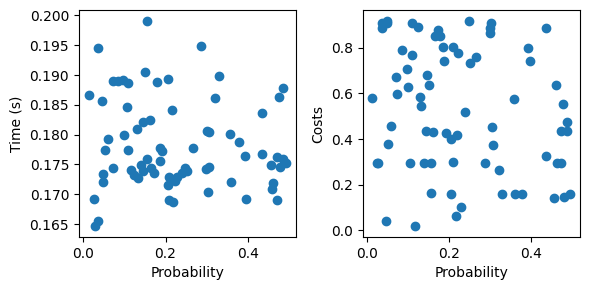

In [58]:
results = pd.read_csv("../results/german/dice_best_sol_2.csv")
summarize_results(results)

Time: 23.583 +- 50.549
Costs: 0.060 +- 0.060
Outliers: 0.000


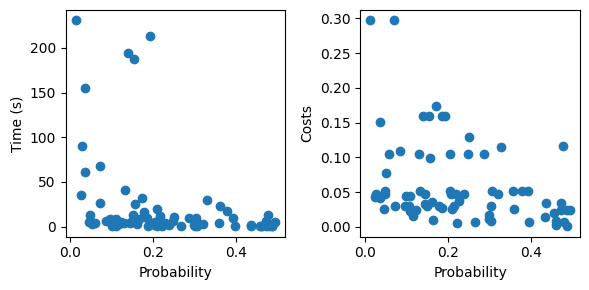

In [68]:
results = pd.read_csv("../results/german/mapofcem_best_sol_2.csv")
summarize_results(results)